In [31]:
import multiprocessing
multiprocessing.cpu_count()


2

In [32]:
import torch.backends.cudnn as cudnn

cudnn.benchmark = True   # lets cuDNN pick fastest conv algos


In [33]:
# If you're in Colab, most of these are already installed.
!pip install torch torchvision facenet-pytorch tqdm

import os
import random
import zipfile
from glob import glob

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from PIL import Image

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
from torchvision.utils import make_grid


In [34]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [35]:
# Path to your faces dataset ZIP in Drive (EDIT THIS)
DATA_ZIP_PATH = "/content/drive/MyDrive/inpaint_project/archive1.zip"

# Where to extract in Colab
EXTRACT_DIR = "/content/faces_dataset"

os.makedirs(EXTRACT_DIR, exist_ok=True)

with zipfile.ZipFile(DATA_ZIP_PATH, 'r') as zip_ref:
    zip_ref.extractall(EXTRACT_DIR)

print("Extracted to:", EXTRACT_DIR)
print("Some files:", sorted(glob(os.path.join(EXTRACT_DIR, '**', '*.*'), recursive=True))[:10])


Extracted to: /content/faces_dataset
Some files: ['/content/faces_dataset/Humans/1 (1).jpeg', '/content/faces_dataset/Humans/1 (1).jpg', '/content/faces_dataset/Humans/1 (1).png', '/content/faces_dataset/Humans/1 (10).jpeg', '/content/faces_dataset/Humans/1 (10).jpg', '/content/faces_dataset/Humans/1 (10).png', '/content/faces_dataset/Humans/1 (100).jpg', '/content/faces_dataset/Humans/1 (100).png', '/content/faces_dataset/Humans/1 (1000).jpg', '/content/faces_dataset/Humans/1 (1001).jpg']


In [36]:
IMG_SIZE = 256
BATCH_SIZE = 8
NUM_WORKERS = 2

class FaceInpaintDataset(Dataset):
    def __init__(self, root_dir, img_size=256):
        super().__init__()
        self.img_size = img_size

        exts = ['*.jpg', '*.jpeg', '*.png', '*.bmp', '*.webp']
        self.files = []
        for e in exts:
            self.files.extend(glob(os.path.join(root_dir, '**', e), recursive=True))
        self.files = sorted(self.files)
        assert len(self.files) > 0, "No images found in dataset folder!"

        self.transform = T.Compose([
            T.Resize((img_size, img_size)),
            T.ToTensor(),                         # [0,1]
        ])

    def __len__(self):
        return len(self.files)

    def _random_mask(self):
        H = W = self.img_size
        mask = torch.ones(1, H, W)

        mode = random.choice(["rect", "multi_rect", "strokes"])

        if mode == "rect":
            rect_h = random.randint(H // 8, H // 2)
            rect_w = random.randint(W // 8, W // 2)
            top = random.randint(0, H - rect_h)
            left = random.randint(0, W - rect_w)
            mask[:, top:top+rect_h, left:left+rect_w] = 0.0

        elif mode == "multi_rect":
            n = random.randint(2, 4)
            for _ in range(n):
                rect_h = random.randint(H // 10, H // 4)
                rect_w = random.randint(W // 10, W // 4)
                top = random.randint(0, H - rect_h)
                left = random.randint(0, W - rect_w)
                mask[:, top:top+rect_h, left:left+rect_w] = 0.0

        else:  # strokes
            n = random.randint(5, 12)
            yy, xx = torch.meshgrid(
                torch.arange(H), torch.arange(W),
                indexing="ij"
            )
            for _ in range(n):
                radius = random.randint(5, 30)
                cy = random.randint(radius, H - radius)
                cx = random.randint(radius, W - radius)
                circle = (xx - cx)**2 + (yy - cy)**2 <= radius**2
                mask[0][circle] = 0.0

        return mask


    def __getitem__(self, idx):
        path = self.files[idx]

        # Open safely and handle palette/transparency
        with Image.open(path) as img:
            # If image has palette or alpha, convert to RGBA then RGB
            if img.mode in ("P", "RGBA", "LA"):
                img = img.convert("RGBA").convert("RGB")
            else:
                img = img.convert("RGB")

            img = self.transform(img)  # (3, H, W)

        mask = self._random_mask()  # (1, H, W)
        masked_img = img * mask          # remove the hole region

        return masked_img, img, mask

# Create dataset & dataloader
DATA_ROOT = EXTRACT_DIR  # or "/content/Humans" or wherever your images are

dataset = FaceInpaintDataset(DATA_ROOT, img_size=IMG_SIZE)
dataloader = DataLoader(
    dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=True,
    persistent_workers=True if NUM_WORKERS > 0 else False
)

print("Using workers:", NUM_WORKERS)
print("Dataset size:", len(dataset))
print("Batch shape:", next(iter(dataloader))[0].shape)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True,
                        num_workers=NUM_WORKERS, pin_memory=True)

len(dataset), next(iter(dataloader))[0].shape


Using workers: 2
Dataset size: 7201
Batch shape: torch.Size([8, 3, 256, 256])


(7201, torch.Size([8, 3, 256, 256]))

In [37]:
class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.net(x)


class UNetGenerator(nn.Module):
    """
    Input:  4 channels -> [masked_img (3) + mask (1)]
    Output: 3 channels -> completed RGB image
    """
    def __init__(self, in_ch=4, out_ch=3):
        super().__init__()
        features = [64, 128, 256, 512]

        self.down1 = DoubleConv(in_ch, features[0])
        self.pool1 = nn.MaxPool2d(2)
        self.down2 = DoubleConv(features[0], features[1])
        self.pool2 = nn.MaxPool2d(2)
        self.down3 = DoubleConv(features[1], features[2])
        self.pool3 = nn.MaxPool2d(2)
        self.down4 = DoubleConv(features[2], features[3])
        self.pool4 = nn.MaxPool2d(2)

        self.bottleneck = DoubleConv(features[3], features[3] * 2)  # 512 -> 1024

        self.up4 = nn.ConvTranspose2d(features[3] * 2, features[3], kernel_size=2, stride=2)
        self.conv4 = DoubleConv(features[3] * 2, features[3])
        self.up3 = nn.ConvTranspose2d(features[3], features[2], kernel_size=2, stride=2)
        self.conv3 = DoubleConv(features[2] * 2, features[2])
        self.up2 = nn.ConvTranspose2d(features[2], features[1], kernel_size=2, stride=2)
        self.conv2 = DoubleConv(features[1] * 2, features[1])
        self.up1 = nn.ConvTranspose2d(features[1], features[0], kernel_size=2, stride=2)
        self.conv1 = DoubleConv(features[0] * 2, features[0])

        self.final = nn.Conv2d(features[0], out_ch, kernel_size=1)
        self.tanh = nn.Tanh()

    def forward(self, x):
        # Encoder
        d1 = self.down1(x)
        p1 = self.pool1(d1)
        d2 = self.down2(p1)
        p2 = self.pool2(d2)
        d3 = self.down3(p2)
        p3 = self.pool3(d3)
        d4 = self.down4(p3)
        p4 = self.pool4(d4)

        # Bottleneck
        bn = self.bottleneck(p4)

        # Decoder
        u4 = self.up4(bn)
        u4 = torch.cat([u4, d4], dim=1)
        u4 = self.conv4(u4)

        u3 = self.up3(u4)
        u3 = torch.cat([u3, d3], dim=1)
        u3 = self.conv3(u3)

        u2 = self.up2(u3)
        u2 = torch.cat([u2, d2], dim=1)
        u2 = self.conv2(u2)

        u1 = self.up1(u2)
        u1 = torch.cat([u1, d1], dim=1)
        u1 = self.conv1(u1)

        out = self.final(u1)
        out = self.tanh(out)  # output in [-1,1]
        return out


In [38]:
class PatchDiscriminator(nn.Module):
    """
    PatchGAN: classify each N×N patch as real/fake.
    Input: 3xHxW image (either real or completed).
    """
    def __init__(self, in_ch=3):
        super().__init__()
        def block(in_c, out_c, normalize=True):
            layers = [nn.Conv2d(in_c, out_c, kernel_size=4, stride=2, padding=1)]
            if normalize:
                layers.append(nn.BatchNorm2d(out_c))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *block(in_ch, 64, normalize=False),
            *block(64, 128),
            *block(128, 256),
            *block(256, 512),
            nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=1)  # output: (B,1,H',W')
        )

    def forward(self, x):
        return self.model(x)


In [39]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

G = UNetGenerator(in_ch=4, out_ch=3).to(device)
D = PatchDiscriminator(in_ch=3).to(device)

# GAN loss (BCE with logits)
criterion_gan = nn.BCEWithLogitsLoss().to(device)
# L1 loss
criterion_l1 = nn.L1Loss().to(device)

lr = 2e-4
beta1 = 0.5
beta2 = 0.999

optimizer_G = torch.optim.Adam(G.parameters(), lr=lr, betas=(beta1, beta2))
optimizer_D = torch.optim.Adam(D.parameters(), lr=lr, betas=(beta1, beta2))

# For labels
def real_labels(tensor):
    return torch.ones_like(tensor, device=device)

def fake_labels(tensor):
    return torch.zeros_like(tensor, device=device)


Using device: cuda


In [40]:
def denorm(t):
    # t: tensor in [0,1] or [-1,1] – here our G uses tanh, so [-1,1].
    # Real images from dataset are [0,1]; we will convert them to [-1,1] before feeding G.
    return (t + 1) / 2.0  # [-1,1] -> [0,1]


def show_batch(masked, completed, gt, max_n=4):
    """
    masked, completed, gt: tensors in [-1,1] shape (B,3,H,W)
    """
    masked = denorm(masked[:max_n].cpu())
    completed = denorm(completed[:max_n].cpu())
    gt = denorm(gt[:max_n].cpu())

    rows = []
    for m, c, g in zip(masked, completed, gt):
        rows.extend([m, c, g])
    grid = make_grid(rows, nrow=3)
    npimg = grid.numpy()
    plt.figure(figsize=(8, 8))
    plt.axis('off')
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


In [41]:
import torch.nn.functional as F
from torchvision.models import vgg19, VGG19_Weights
from facenet_pytorch import InceptionResnetV1
from torch.cuda.amp import autocast, GradScaler

# AMP scalers
scaler_G = GradScaler()
scaler_D = GradScaler()

# -------- VGG features (perceptual) ----------
class VGGFeatureExtractor(nn.Module):
    def __init__(self, layer_ids=[2, 7, 12, 21]):
        super().__init__()
        vgg = vgg19(weights=VGG19_Weights.DEFAULT).features
        self.layers = nn.ModuleList()
        prev = 0
        for lid in layer_ids:
            block = nn.Sequential(*[vgg[i] for i in range(prev, lid)])
            self.layers.append(block)
            prev = lid
        for p in self.parameters():
            p.requires_grad = False

    def forward(self, x):
        x = (x + 1.0) / 2.0
        mean = torch.tensor([0.485, 0.456, 0.406], device=x.device).view(1,3,1,1)
        std  = torch.tensor([0.229, 0.224, 0.225], device=x.device).view(1,3,1,1)
        x = (x - mean) / std
        feats = []
        out = x
        for layer in self.layers:
            out = layer(out)
            feats.append(out)
        return feats

vgg_feat = VGGFeatureExtractor().to(device).eval()

# -------- Identity network ----------
id_net = InceptionResnetV1(pretrained='vggface2').eval().to(device)
for p in id_net.parameters():
    p.requires_grad = False

def face_embed(x):
    x_01 = (x + 1.0) / 2.0
    x_resized = F.interpolate(x_01, size=(160, 160),
                              mode="bilinear", align_corners=False)
    return id_net(x_resized)

# -------- Edge helper ----------
def image_gradients(x):
    dx = x[:, :, :, 1:] - x[:, :, :, :-1]
    dy = x[:, :, 1:, :] - x[:, :, :-1, :]
    return dx, dy

# -------- Loss weights ----------
lambda_l1   = 7.0
lambda_perc = 0.2
lambda_id   = 0.1
lambda_edge = 0.5


In [42]:
import os
import torch
from torch.cuda.amp import autocast, GradScaler   # ✅ FIXED IMPORT

# ✅ No need to pass device="cuda" here
scaler_G = GradScaler()
scaler_D = GradScaler()

CKPT_DIR = "/content/drive/MyDrive/inpaint_gan_ckpts"
os.makedirs(CKPT_DIR, exist_ok=True)
CKPT_PATH = os.path.join(CKPT_DIR, "latest.pth")

def save_checkpoint(epoch):
    ckpt = {
        "epoch": epoch,
        "G": G.state_dict(),
        "D": D.state_dict(),
        "opt_G": optimizer_G.state_dict(),
        "opt_D": optimizer_D.state_dict(),
        "scaler_G": scaler_G.state_dict(),
        "scaler_D": scaler_D.state_dict(),
    }
    torch.save(ckpt, CKPT_PATH)
    print(f"✅ Saved checkpoint at epoch {epoch} -> {CKPT_PATH}")

# -----------------------------
# TRY TO RESUME TRAINING HERE
# -----------------------------
start_epoch = 1

if os.path.exists(CKPT_PATH):
    print("🔄 Found checkpoint, loading:", CKPT_PATH)
    ckpt = torch.load(CKPT_PATH, map_location=device)

    G.load_state_dict(ckpt["G"])
    D.load_state_dict(ckpt["D"])
    optimizer_G.load_state_dict(ckpt["opt_G"])
    optimizer_D.load_state_dict(ckpt["opt_D"])
    scaler_G.load_state_dict(ckpt["scaler_G"])
    scaler_D.load_state_dict(ckpt["scaler_D"])

    start_epoch = ckpt["epoch"] + 1
    print("Resuming from epoch", start_epoch)
else:
    print("No checkpoint found. Starting from scratch.")


🔄 Found checkpoint, loading: /content/drive/MyDrive/inpaint_gan_ckpts/latest.pth
Resuming from epoch 79


In [43]:
import torch.nn.functional as F
from facenet_pytorch import InceptionResnetV1

# ---------- Identity network (Face embeddings) ----------
id_net = InceptionResnetV1(pretrained='vggface2').eval().to(device)
for p in id_net.parameters():
    p.requires_grad = False

def face_embed(x):
    x_01 = (x + 1.0) / 2.0              # [-1,1] -> [0,1]
    x_resized = F.interpolate(
        x_01, size=(160, 160),
        mode="bilinear", align_corners=False
    )
    return id_net(x_resized)

# ---------- Edge helper ----------
def image_gradients(x):
    # x: (B,3,H,W)
    dx = x[:, :, :, 1:] - x[:, :, :, :-1]
    dy = x[:, :, 1:, :] - x[:, :, :-1, :]
    return dx, dy

# loss weights
lambda_l1   = 7.0     # you already set this
lambda_perc = 0.2     # small bump for sharper perceptual details
lambda_id   = 0.1     # identity loss weight
lambda_edge = 0.5     # edge loss weight



📌 Training epochs 79 → 90 in this session.



Epoch [79/90]  G_loss: 6.4186  D_loss: 0.5270
✅ Saved checkpoint at epoch 79 -> /content/drive/MyDrive/inpaint_gan_ckpts/latest.pth


Epoch [80/90]  G_loss: 4.7085  D_loss: 0.5850
✅ Saved checkpoint at epoch 80 -> /content/drive/MyDrive/inpaint_gan_ckpts/latest.pth
Showing [masked | completed | ground truth]:


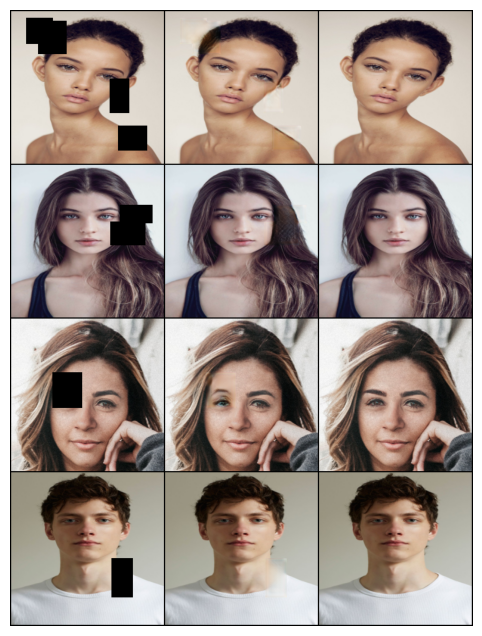

Epoch [81/90]  G_loss: 4.2648  D_loss: 0.6087
✅ Saved checkpoint at epoch 81 -> /content/drive/MyDrive/inpaint_gan_ckpts/latest.pth


Epoch [82/90]  G_loss: 4.0081  D_loss: 0.6237
✅ Saved checkpoint at epoch 82 -> /content/drive/MyDrive/inpaint_gan_ckpts/latest.pth


Epoch [83/90]  G_loss: 3.8592  D_loss: 0.6334
✅ Saved checkpoint at epoch 83 -> /content/drive/MyDrive/inpaint_gan_ckpts/latest.pth


Epoch [84/90]  G_loss: 3.7186  D_loss: 0.6413
✅ Saved checkpoint at epoch 84 -> /content/drive/MyDrive/inpaint_gan_ckpts/latest.pth


Epoch [85/90]  G_loss: 3.6348  D_loss: 0.6457
✅ Saved checkpoint at epoch 85 -> /content/drive/MyDrive/inpaint_gan_ckpts/latest.pth
Showing [masked | completed | ground truth]:


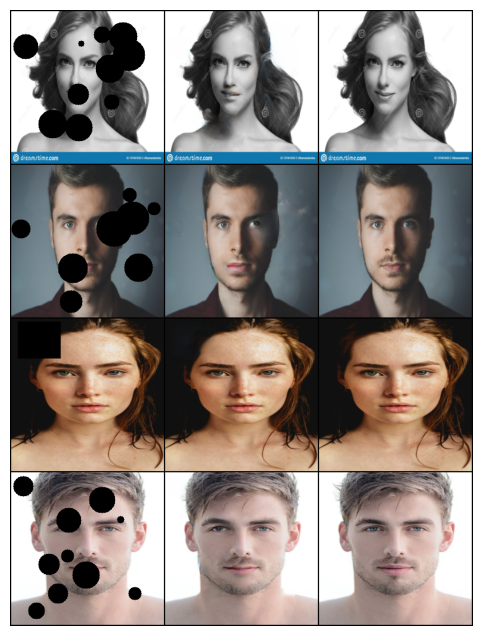

Epoch [86/90]  G_loss: 3.5785  D_loss: 0.6470
✅ Saved checkpoint at epoch 86 -> /content/drive/MyDrive/inpaint_gan_ckpts/latest.pth


Epoch [87/90]  G_loss: 3.5233  D_loss: 0.6540
✅ Saved checkpoint at epoch 87 -> /content/drive/MyDrive/inpaint_gan_ckpts/latest.pth


Epoch [88/90]  G_loss: 3.5003  D_loss: 0.6506
✅ Saved checkpoint at epoch 88 -> /content/drive/MyDrive/inpaint_gan_ckpts/latest.pth


Epoch [89/90]  G_loss: 3.4860  D_loss: 0.6539
✅ Saved checkpoint at epoch 89 -> /content/drive/MyDrive/inpaint_gan_ckpts/latest.pth


Epoch [90/90]  G_loss: 3.4773  D_loss: 0.6541
✅ Saved checkpoint at epoch 90 -> /content/drive/MyDrive/inpaint_gan_ckpts/latest.pth
Showing [masked | completed | ground truth]:


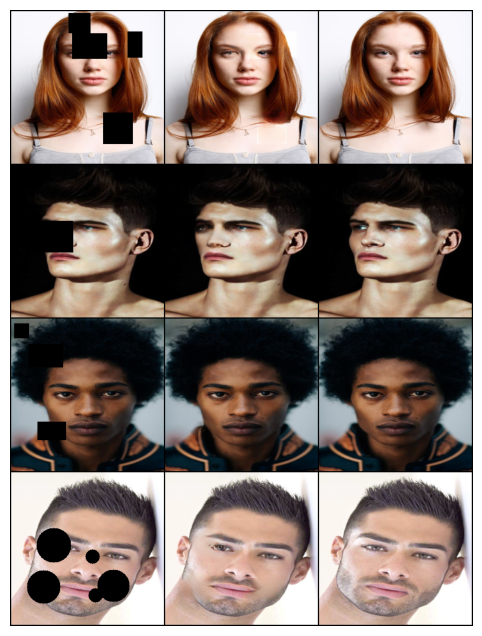

In [45]:
lambda_l1 = 7.0
sample_every = 5

TOTAL_EPOCHS = 90         # final total epochs you want
EPOCHS_PER_RUN = 20       # max epochs per colab run (to avoid GPU limits)

# Compute the end epoch for this session
end_epoch = min(start_epoch + EPOCHS_PER_RUN - 1, TOTAL_EPOCHS)
print(f"\n📌 Training epochs {start_epoch} → {end_epoch} in this session.\n")

G_losses = []
D_losses = []

for epoch in range(start_epoch, end_epoch + 1):

    G.train()
    D.train()

    epoch_g_loss = 0.0
    epoch_d_loss = 0.0

    for masked_img, gt_img, mask in tqdm(dataloader, desc=f"Epoch {epoch}/{TOTAL_EPOCHS}", leave=False):
        masked_img = masked_img.to(device)         # [0,1]
        gt_img = gt_img.to(device)                 # [0,1]
        mask = mask.to(device)                     # 1=known,0=hole

        gt = gt_img * 2.0 - 1.0
        masked = masked_img * 2.0 - 1.0

        # ======================
        # 1. Train Discriminator
        # ======================
        optimizer_D.zero_grad()

        with autocast():
            input_G = torch.cat([masked, mask], dim=1)
            fake_pred = G(input_G)
            comp_fake = mask * gt + (1 - mask) * fake_pred

            # Real / Fake
            out_real = D(gt)
            loss_D_real = criterion_gan(out_real, real_labels(out_real))

            out_fake = D(comp_fake.detach())
            loss_D_fake = criterion_gan(out_fake, fake_labels(out_fake))

            loss_D = 0.5 * (loss_D_real + loss_D_fake)

        scaler_D.scale(loss_D).backward()
        scaler_D.step(optimizer_D)
        scaler_D.update()

        # ==================
        # 2. Train Generator
        # ==================
        optimizer_G.zero_grad()

        with autocast():
            # forward generator
            input_G = torch.cat([masked, mask], dim=1)
            fake_pred = G(input_G)                     # (B,3,H,W) in [-1,1]
            comp_fake = mask * gt + (1 - mask) * fake_pred

            # ---- adversarial loss (global D) ----
            out_fake_for_G = D(comp_fake)
            loss_G_adv = criterion_gan(
                out_fake_for_G,
                real_labels(out_fake_for_G)
            )

            # ---- L1 loss on hole region ----
            hole_mask = 1 - mask                      # (B,1,H,W)
            l1 = (torch.abs(fake_pred - gt) * hole_mask).sum() / (hole_mask.sum() + 1e-8)

            # ---- perceptual loss (VGG) ----
            with torch.no_grad():
                feats_gt = vgg_feat(gt)
            feats_fake = vgg_feat(fake_pred)

            perc_loss = 0.0
            for f_gt, f_fake in zip(feats_gt, feats_fake):
                perc_loss += F.l1_loss(f_fake, f_gt)

            # ---- identity loss (face embeddings) ----
            with torch.no_grad():
                emb_gt = face_embed(gt)               # (B,512)
            emb_fake = face_embed(fake_pred)          # (B,512)

            cos_sim = F.cosine_similarity(emb_fake, emb_gt, dim=1)  # (B,)
            id_loss = (1.0 - cos_sim).mean()

            # ---- edge loss (image gradients) ----
            dx_fake, dy_fake = image_gradients(fake_pred)
            dx_gt,   dy_gt   = image_gradients(gt)

            # restrict edge loss to hole region only
            edge_mask_x = hole_mask[:, :, :, 1:]
            edge_mask_y = hole_mask[:, :, 1:, :]

            edge_mask_x = edge_mask_x.expand_as(dx_fake)
            edge_mask_y = edge_mask_y.expand_as(dy_fake)

            edge_loss_x = ((dx_fake - dx_gt).abs() * edge_mask_x).sum() / (edge_mask_x.sum() + 1e-8)
            edge_loss_y = ((dy_fake - dy_gt).abs() * edge_mask_y).sum() / (edge_mask_y.sum() + 1e-8)
            edge_loss = edge_loss_x + edge_loss_y

            # ---- total generator loss ----
            loss_G = (
                loss_G_adv +
                lambda_l1   * l1 +
                lambda_perc * perc_loss +
                lambda_id   * id_loss +
                lambda_edge * edge_loss
            )

        scaler_G.scale(loss_G).backward()
        scaler_G.step(optimizer_G)
        scaler_G.update()

        epoch_g_loss += loss_G.item()
        epoch_d_loss += loss_D.item()

    epoch_g_loss /= len(dataloader)
    epoch_d_loss /= len(dataloader)
    G_losses.append(epoch_g_loss)
    D_losses.append(epoch_d_loss)

    print(f"Epoch [{epoch}/{TOTAL_EPOCHS}]  G_loss: {epoch_g_loss:.4f}  D_loss: {epoch_d_loss:.4f}")

    # 🔐 save checkpoint EVERY epoch (you can change to every 2–5 epochs if you like)
    save_checkpoint(epoch)

    if epoch % sample_every == 0:
        G.eval()
        with torch.no_grad():
            masked_img, gt_img, mask = next(iter(dataloader))
            masked_img = masked_img.to(device)
            gt_img = gt_img.to(device)
            mask = mask.to(device)

            gt = gt_img * 2.0 - 1.0
            masked = masked_img * 2.0 - 1.0
            input_G = torch.cat([masked, mask], dim=1)
            fake_pred = G(input_G)
            comp_fake = mask * gt + (1 - mask) * fake_pred

            print("Showing [masked | completed | ground truth]:")
            show_batch(masked, comp_fake, gt)


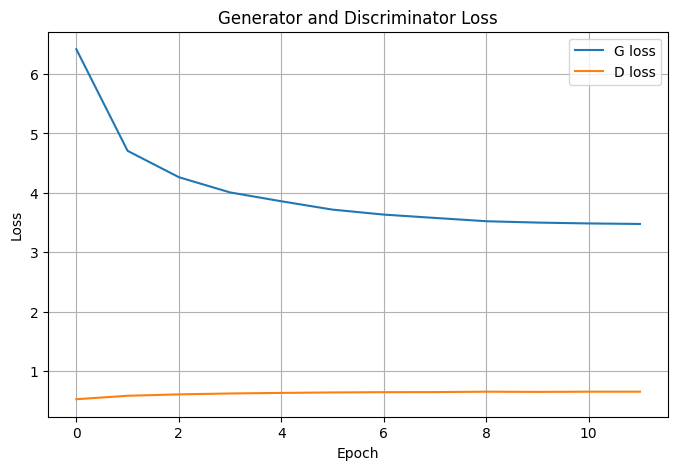

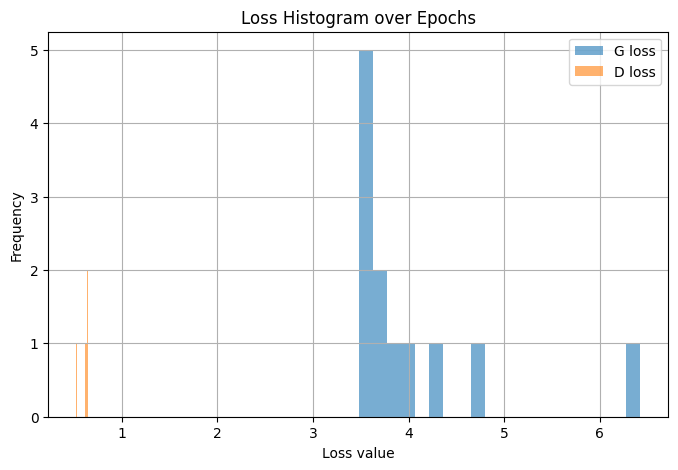

In [46]:
import matplotlib.pyplot as plt

# ---- Line plot of losses ----
plt.figure(figsize=(8,5))
plt.plot(G_losses, label="G loss")
plt.plot(D_losses, label="D loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Generator and Discriminator Loss")
plt.legend()
plt.grid(True)
plt.show()

# ---- Histogram of final epoch batch losses (optional) ----
plt.figure(figsize=(8,5))
plt.hist(G_losses, bins=20, alpha=0.6, label="G loss")
plt.hist(D_losses, bins=20, alpha=0.6, label="D loss")
plt.xlabel("Loss value")
plt.ylabel("Frequency")
plt.title("Loss Histogram over Epochs")
plt.legend()
plt.grid(True)
plt.show()


In [47]:
from torch.utils.data import random_split, DataLoader

# 90% train, 10% test
test_ratio = 0.1
test_size = int(len(dataset) * test_ratio)
train_size = len(dataset) - test_size

train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

test_loader = DataLoader(
    test_dataset,
    batch_size=8,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

print("Test samples:", len(test_dataset))


Test samples: 720


In [48]:
import numpy as np
from skimage.metrics import peak_signal_noise_ratio, structural_similarity

G.eval()
psnr_values = []
ssim_values = []

with torch.no_grad():
    for masked_img, gt_img, mask in test_loader:
        masked_img = masked_img.to(device)   # [0,1]
        gt_img = gt_img.to(device)           # [0,1]
        mask = mask.to(device)

        gt = gt_img * 2.0 - 1.0             # [-1,1]
        masked = masked_img * 2.0 - 1.0

        input_G = torch.cat([masked, mask], dim=1)
        fake_pred = G(input_G)              # [-1,1]
        comp_fake = mask * gt + (1 - mask) * fake_pred

        # convert to [0,1] for metrics
        gt_01 = gt_img                      # already [0,1]
        out_01 = (comp_fake + 1.0) / 2.0    # [-1,1] -> [0,1]

        # loop over batch
        b = gt_01.size(0)
        for i in range(b):
            gt_np = gt_01[i].permute(1,2,0).cpu().numpy()
            out_np = out_01[i].permute(1,2,0).cpu().numpy()

            psnr_val = peak_signal_noise_ratio(gt_np, out_np, data_range=1.0)
            ssim_val = structural_similarity(gt_np, out_np, channel_axis=2, data_range=1.0)

            psnr_values.append(psnr_val)
            ssim_values.append(ssim_val)

mean_psnr = float(np.mean(psnr_values))
mean_ssim = float(np.mean(ssim_values))
acc_percent = mean_ssim * 100.0

print(f"Mean PSNR on test set: {mean_psnr:.2f} dB")
print(f"Mean SSIM on test set: {mean_ssim:.4f}")
print(f'Approx. "percentage accuracy" (SSIM * 100): {acc_percent:.2f}%')


Mean PSNR on test set: 31.93 dB
Mean SSIM on test set: 0.9597
Approx. "percentage accuracy" (SSIM * 100): 95.97%


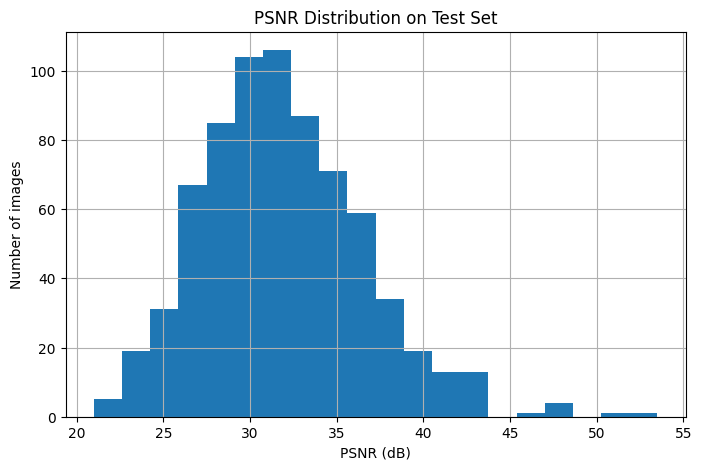

In [49]:
plt.figure(figsize=(8,5))
plt.hist(psnr_values, bins=20)
plt.xlabel("PSNR (dB)")
plt.ylabel("Number of images")
plt.title("PSNR Distribution on Test Set")
plt.grid(True)
plt.show()


Test samples [masked | completed | ground truth]:


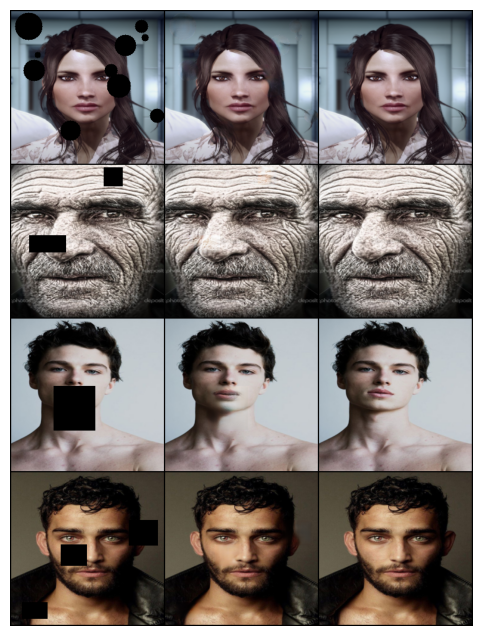

In [50]:
# Show a few TEST images: [masked | completed | ground truth]

G.eval()   # inference mode

with torch.no_grad():
    # get one batch from the test loader
    masked_img, gt_img, mask = next(iter(test_loader))

    masked_img = masked_img.to(device)   # [0,1]
    gt_img = gt_img.to(device)           # [0,1]
    mask = mask.to(device)

    # convert to [-1,1] like during training
    gt = gt_img * 2.0 - 1.0
    masked = masked_img * 2.0 - 1.0

    # run generator
    input_G = torch.cat([masked, mask], dim=1)   # (B,4,H,W)
    fake_pred = G(input_G)                       # (B,3,H,W) in [-1,1]
    comp_fake = mask * gt + (1 - mask) * fake_pred

    print("Test samples [masked | completed | ground truth]:")
    show_batch(masked, comp_fake, gt)


In [51]:
SAVE_DIR = "/content/drive/MyDrive/inpaint_gan_model"
os.makedirs(SAVE_DIR, exist_ok=True)

torch.save(G.state_dict(), f"{SAVE_DIR}/generator_final.pth")
print("✅ Generator saved as generator_final.pth")


✅ Generator saved as generator_final.pth


FileNotFoundError: Cannot find file: /content/generator_final.pth